## Convolutional Layerのスクラッチ実装

In [18]:
import torchvision
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True)
im, label = dataset[0]
im = transforms.ToTensor()(im)[0, :, :]

In [43]:
# im, label = dataset[0]

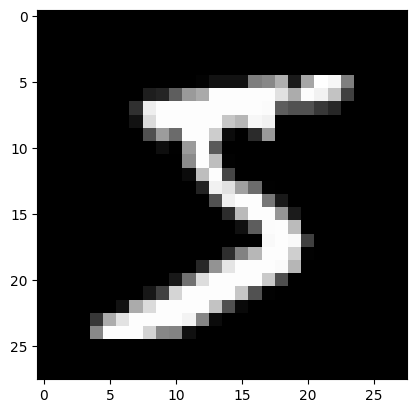

In [36]:
plt.imshow(im, cmap='gray')

In [37]:
top_edge_filter = torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

In [38]:
top_edge_filter

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [71]:
df = pd.DataFrame(im)
df.style.format(precision=2).set_properties(**{'font-size': '7pt'}).background_gradient('Greys_r')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [57]:
im_h, im_w = im.shape
f_h, f_w = top_edge_filter.shape
print("画像の大きさ：", im_h, im_w)
print("フィルタの大きさ：", f_h, f_w)

画像の大きさ： 28 28
フィルタの大きさ： 3 3


In [63]:
def apply_filter(im, filter):
    output_data = []
    for i in range(im_h - f_h + 1):
        row = []
        for j in range(im_w - f_w + 1):
            row.append((im[i:i+f_h, j:j+f_w] * filter).sum().item())
        output_data.append(row)
    return torch.tensor(output_data)

In [65]:
filtered_im = apply_filter(im, top_edge_filter)
filtered_im.shape

torch.Size([26, 26])

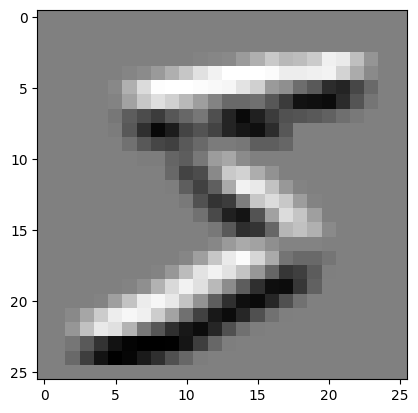

In [68]:
plt.imshow(filtered_im, cmap='gray')

## CNN構築

In [10]:
conv_model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=1),
    nn.Flatten()
)

In [11]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [12]:
X = torch.randn((8, 1, 28, 28))
output = conv_model(X)

In [13]:
output.shape

torch.Size([8, 10])

In [14]:
output.numel()

80

In [15]:
torch.tensor([params.numel() for params in conv_model.parameters()]).sum()

tensor(9034)

## CNN学習

In [3]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4)
X_train, y_train = next(iter(train_loader))
X_train.shape

100%|██████████| 9912422/9912422 [00:00<00:00, 106028841.50it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29639269.35it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30903211.00it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13039376.30it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])

In [4]:
y_train

tensor([8, 6, 4, 1, 7, 5, 9, 5, 6, 1, 9, 0, 4, 2, 6, 2, 0, 2, 8, 9, 3, 9, 5, 7,
        9, 8, 1, 0, 4, 4, 6, 2, 2, 8, 6, 8, 4, 5, 9, 4, 3, 7, 9, 1, 1, 5, 0, 3,
        0, 4, 4, 7, 9, 9, 0, 7, 3, 1, 0, 0, 0, 6, 0, 7, 7, 0, 9, 5, 3, 6, 1, 9,
        2, 8, 6, 3, 8, 1, 4, 0, 3, 3, 2, 8, 7, 0, 3, 2, 3, 8, 3, 1, 7, 6, 1, 7,
        1, 3, 2, 6, 8, 4, 3, 0, 7, 7, 2, 0, 0, 1, 5, 1, 5, 7, 0, 2, 5, 9, 3, 3,
        3, 3, 6, 7, 6, 4, 3, 1])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_model.to(device)
opt = optim.SGD(conv_model.parameters(), lr=0.03,)
start = time.time()
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=5)
end = time.time()
print(end - start)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                                                           

epoch: 0: train error: 0.1774154376310072, validation error: 0.1768819837819172, validation accuracy: 0.9453125


epoch: 1: train error: 0.15603414406654423, validation error: 0.14587729900509497, validation accuracy: 0.9557950949367089


epoch: 2: train error: 0.13737564177305966, validation error: 0.12507218449034646, validation accuracy: 0.9610363924050633


epoch: 3: train error: 0.12496578111164351, validation error: 0.12186076252167172, validation accuracy: 0.9628164556962026


epoch: 4: train error: 0.11524861080369461, validation error: 0.11376436934158017, validation accuracy: 0.9627175632911392
124.09848833084106


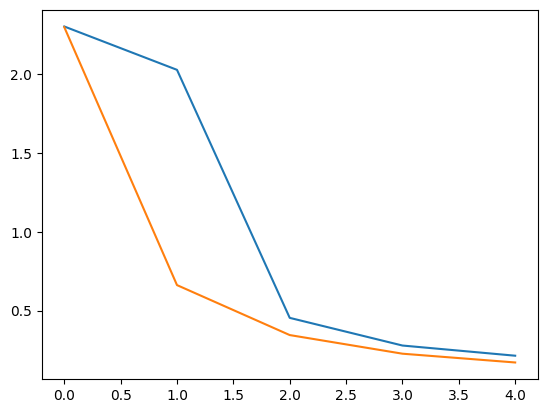

In [24]:
plt.plot(train_losses)
plt.plot(val_losses)